# Visual SLAM

In this SLAM recitation, we will implement a visual SLAM system that uses an OpenCV frontend, a GTSAM backend, and a loop closure module based on a bag-of-words approach. Our objective is to test the system using the abandoned_factory P006 sequence from the TartanAir dataset. To get started, we'll need to access the camera intrinsics, extrinsics, and data format information, which can be found here: https://github.com/castacks/tartanair_tools/blob/master/data_type.md.

In this notebook, we will walk through the implementation of the frontend step-by-step, while visualizing the output of each step. Specifically, we will cover the following topics:

- Loading the dataset
- Selecting keyframes
- Extracting features and tracking them across frames
- Removing outlier matches
- Assigning global IDs to features

## I. Dependency


### 1. Install Python libraries

In [2]:
# install the minslam package in “editable” mode
!pip install -e ..

# install other libraries
!pip install numpy spatialmath-python opencv-python matplotlib gtsam ipympl

# use conda to install gtsam if pip fails
# !conda install gtsam

/home/link/miniconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Obtaining file:///home/link/Projects/minimum-slam
  Preparing metadata (setup.py) ... done
  Attempting uninstall: minslam
    Found existing installation: minslam 0.0.1
    Uninstalling minslam-0.0.1:
      Successfully uninstalled minslam-0.0.1
  Running setup.py develop for minslam
/home/link/miniconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 2. Download dataset
Please download [abadoned_factory P006 dataset](https://drive.google.com/file/d/1Q_fSI0U-IMfv90lyE1Uh78KV2QJheHbv/view?usp=share_link) and extract it to a folder named "data".

In [7]:
import os

# test if we can find the dataset
dataset_folder = '../data/P006/'
print('Check if the data folder exists:',os.path.exists(dataset_folder))

Check if the data folder exists: True


### 3. Import libraries

In [8]:
# this block should run without error

# frontend
import numpy as np
from spatialmath import *
import cv2
import matplotlib.pyplot as plt

# backend
import gtsam
from gtsam.symbol_shorthand import L, X

# our slam implementation
from minslam.data_loader import TartanAirLoader
from minslam.frontend import Frontend
from minslam.params import Params

## II. Frontend

### 1. Load images and trajectory

Loading trajectory from  ../data/P006/pose_left.txt
First 3 lines of TartanAir trajectory file:
5.246845722198486328e+00 -2.774246215820312500e+01 -3.012477874755859375e+00 1.602893229573965073e-03 -3.144130408763885498e-01 1.141050923615694046e-02 9.492163062095642090e-01
5.005289077758789062e+00 -2.763811683654785156e+01 -2.977025032043457031e+00 9.657302871346473694e-03 -3.079342246055603027e-01 2.714120037853717804e-02 9.509713649749755859e-01
4.765544414520263672e+00 -2.753191375732421875e+01 -2.936581373214721680e+00 1.755466312170028687e-02 -3.009457886219024658e-01 4.383775591850280762e-02 9.524713158607482910e-01

First 3 SE3 poses:
[0] =
   0.802    -0.02267  -0.5969    5.247     
   0.02065   0.9997   -0.01022  -27.74     
   0.5969   -0.004132  0.8023   -3.012     
   0         0         0         1         
[1] =
   0.8089   -0.05757  -0.5851    5.005     
   0.04567   0.9983   -0.03508  -27.64     
   0.5862    0.001652  0.8102   -2.977     
   0         0         0      

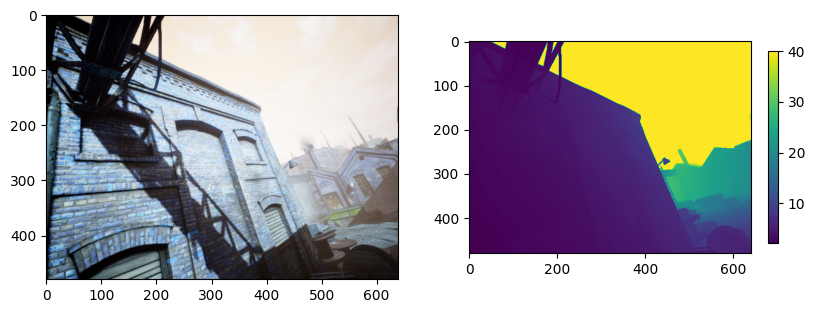

In [9]:
traj_filename = 'pose_left.txt'
traj_path = os.path.join(dataset_folder, traj_filename)
print('Loading trajectory from ', traj_path)

# Have a look at the trajectory file
print('First 3 lines of TartanAir trajectory file:')
with open(traj_path, 'r') as f:
    print(''.join(f.readlines()[:3])) # tx ty tz qx qy qz qw

# load a trajectory
print('First 3 SE3 poses:')
dataset = TartanAirLoader(dataset_folder)
gt_traj = dataset._load_traj('tum', traj_filename, add_timestamps=True)
print(gt_traj[:3])

# set the gt as odom for testing
dataset.set_ground_truth(gt_traj)
dataset.set_odometry(gt_traj)

# load the first frame
dataset.set_curr_index(50)
color, depth = dataset.read_current_rgbd()

# show color and depth horizontally
print('color image data type:', color.dtype)
print('depth image data type:', depth.dtype)
print('depth image range:', f'{depth.min()} - {depth.max()}')
axes = plt.subplots(1, 2, figsize=(10, 5))[1]
axes[0].imshow(color)
axes[1].imshow(depth.clip(0,40))
# colorbar height equal to image height
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1], shrink=0.5)
plt.show()

### 2. Keyframe selection

To reduce the number of frames we need to process and ensure sufficient transform for landmark triangulation, we implement a keyframe selection algorithm in which we determine whether to choose an incoming frame as a keyframe. To do this, we define the distance between two poses as $\lVert Log (X_{i}^{-1} X_{i+1}) \rVert$, and if this distance is greater than a specified threshold, we add the new frame as a keyframe.

The figure below illustrates the effect of increasing the threshold on the number of keyframes we obtain:

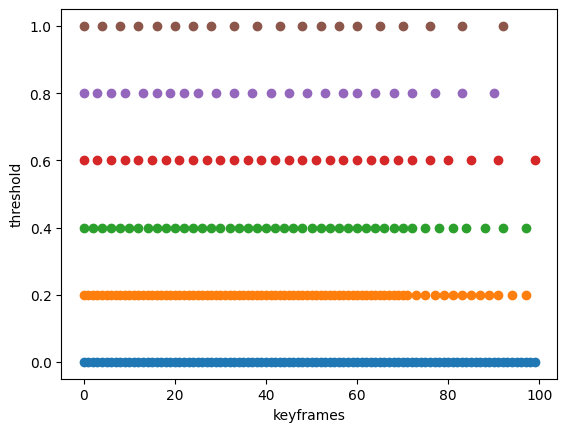

In [10]:
# intialize our frontend implementation
params = Params('../params/tartanair.yaml')
frontend = Frontend(params)

# The keyframe_selection function accepts a pose and returns a boolean.
# The first frame is always a keyframe, then we check if the motion is
# large enough.
pose = dataset.read_current_odometry()
is_keyframe = frontend.keyframe_selection(pose)

# What if we set the threshold to different values?
is_keyframe_dict = {}
for threshold in np.arange(0, 1.1, 0.2):
    frontend.params['frontend']['keyframe']['threshold'] = threshold
    is_keyframe_dict[threshold] = np.zeros(100)
    for i in range(100):
        dataset.set_curr_index(i)
        pose = dataset.read_current_odometry()
        is_keyframe_dict[threshold][i] = frontend.keyframe_selection(pose)
        if is_keyframe_dict[threshold][i]:
            frontend.add_keyframe(pose, color, depth)
    plt.scatter(np.arange(100), np.where(is_keyframe_dict[threshold]==1, threshold, None), label=f'threshold={threshold}')
plt.xlabel('keyframes')
plt.ylabel('threshold')
plt.show()

### 3. Extract features and generate matches

To detect and describe features in the image, we'll be using the [Scale-Invariant Feature Transform (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). Other options such as ORB, FAST, and AKAZE are also available. To track the features, we could use a brute-force matcher to compare each pair of feature descriptors and choose the best matches. However, in this case we'll be using an  [optical flow method](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html) that tracks how image patches (3x3) move across different frames. This method typically provides better tracking results and more consistent runtime.

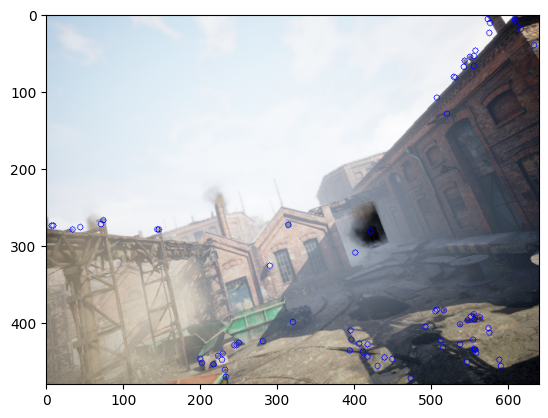

In [16]:
# clear previous states
params = Params('../params/tartanair.yaml')
frontend = Frontend(params)

# add a keyframe
dataset.set_curr_index(100)
pose = dataset.read_current_odometry()
color, depth = dataset.read_current_rgbd()
frontend.add_keyframe(pose, color, depth)

# extract features
frontend.extract_features()
frontend.plot_features()
plt.show()

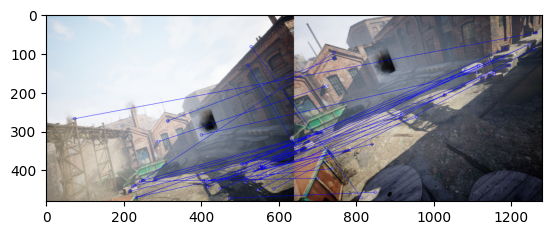

In [17]:
# add another keyframe
dataset.set_curr_index(150)
pose = dataset.read_current_odometry()
color, depth = dataset.read_current_rgbd()
frontend.add_keyframe(pose, color, depth)

# match features
frontend.extract_features()
frontend.match_features('bruteforce')
frontend.plot_matches()
plt.show()

### 4. Remove match outliers

To remove incorrect matches, we'll be using [`cv2.findFundamentalMat`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a). This function uses the [epipolar geometry model](https://web.stanford.edu/class/cs231a/course_notes/03-epipolar-geometry.pdf) to describe the relationship between matches, based on the fundamental matrix. It then detects outliers based on how well a match fits the model.

![epipolar geometry](assets/epipolar%20geometry.png)

number of matches before outlier rejection: 298


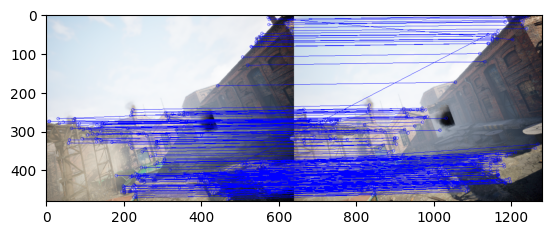

In [8]:
# to test whether the algorithm works, we manually add a wrong match here
frontend.curr_frame.points.append(np.array([500,50], dtype=np.float32))
frontend.curr_frame.matches.append(cv2.DMatch(100, len(frontend.curr_frame.points)-1, 0))
frontend.plot_matches()
print('number of matches before outlier rejection:', len(frontend.curr_frame.matches))

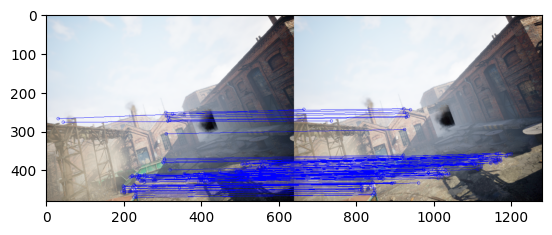

In [9]:
# after removing outliers, the wrong match we added should be removed
frontend.eliminate_outliers()
frontend.plot_matches()
plt.show()

### 5. Assign global ID

Then, for each tracked feature, we assign a global id to it. The global id won't change across the frames.

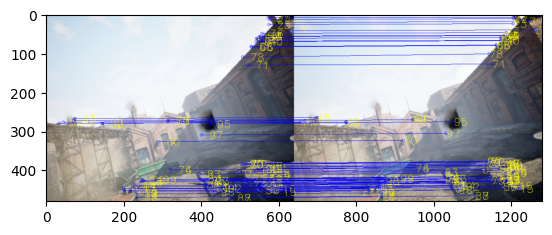

In [10]:
# clear previous states
params = Params('../params/tartanair.yaml')
# we lower the feature number to make the plot easier to read
params['frontend']['feature']['number'] = 100
frontend = Frontend(params)

# add a keyframe
dataset.set_curr_index(100)
pose = dataset.read_current_odometry()
color, depth = dataset.read_current_rgbd()
frontend.add_keyframe(pose, color, depth)
frontend.extract_features()
frontend.assign_global_id()

# add another keyframe
dataset.set_curr_index(102)
pose = dataset.read_current_odometry()
color, depth = dataset.read_current_rgbd()
frontend.add_keyframe(pose, color, depth)
frontend.extract_features()
frontend.match_features()
frontend.eliminate_outliers()
frontend.assign_global_id()

frontend.plot_matches(with_global_id=True)
plt.show()

### 6. Test the frontend

Finally, we can construct a working frontend!!

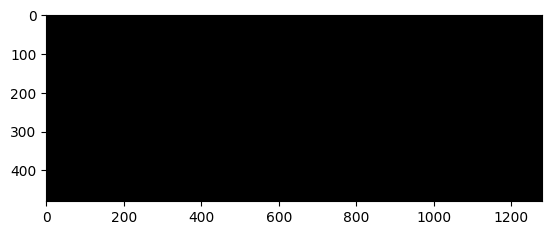

In [11]:
# clear previous states
params = Params('../params/tartanair.yaml')
frontend = Frontend(params)
dataset.set_curr_index(100)

fig, ax = plt.subplots()
im = ax.imshow(np.zeros([480, 1280, 3]))     # A tuple unpacking to unpack the only plot

# run the whole pipeline once
def run_once(frame_num):
    pose = dataset.read_current_odometry()
    while not frontend.keyframe_selection(pose):
        if not dataset.load_next_frame():
            break
        pose = dataset.read_current_odometry()
    color, depth = dataset.read_current_rgbd()
    frontend.add_keyframe(pose, color, depth)
    print(f'--- Added keyframe {frontend.frame_id} (seq id: {dataset.curr_index}) ---')
    if frontend.frame_id > 0:
        frontend.match_features()
        frontend.eliminate_outliers()
    more_points_n = params['frontend']['feature']['number']-len(frontend.curr_frame.points)
    print('current point number:', len(frontend.curr_frame.points))
    if more_points_n>0:
        print('extracting more features:', more_points_n)
        frontend.extract_features(more_points_n, append_mode=True)
    frontend.assign_global_id()
    img = frontend.plot_matches(with_global_id=True)
    im.set_array(img)
    return [im]

--- Added keyframe 0 (seq id: 100) ---
current point number: 0
extracting more features: 300
--- Added keyframe 1 (seq id: 104) ---
current point number: 290
extracting more features: 10
--- Added keyframe 2 (seq id: 108) ---
current point number: 259
extracting more features: 41
--- Added keyframe 3 (seq id: 112) ---
current point number: 253
extracting more features: 47
--- Added keyframe 4 (seq id: 116) ---
current point number: 276
extracting more features: 24
--- Added keyframe 5 (seq id: 122) ---
current point number: 281
extracting more features: 19
--- Added keyframe 6 (seq id: 128) ---
current point number: 288
extracting more features: 12
--- Added keyframe 7 (seq id: 133) ---
current point number: 299
extracting more features: 1
--- Added keyframe 8 (seq id: 138) ---
current point number: 301
--- Added keyframe 9 (seq id: 142) ---
current point number: 281
extracting more features: 19
--- Added keyframe 10 (seq id: 145) ---
current point number: 299
extracting more features:

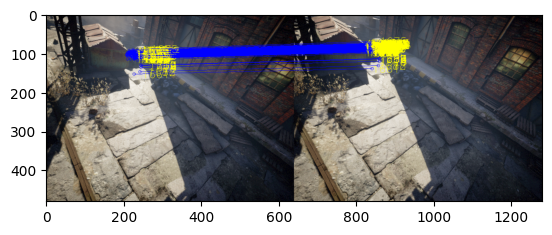

In [12]:
# generate tracking animation
from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, run_once, frames=100)
anim.save('recitation_tracking.mp4', writer='ffmpeg', fps=10)